# Implementación de ALVINN

In [2]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion 

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño 
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

import sqlite3
import cv2

## Creación del DataFrame

### Preprocesamiento de imagen

In [3]:
def preprocess(img):
    p_img = cv2.resize(img, (64, 60))
    p_img = cv2.cvtColor(p_img, cv2.COLOR_BGR2GRAY)
    p_img  = p_img/255.
    return p_img 

### Carga de raw data

In [73]:
# Creación de df
conn = sqlite3.connect('datos.sqlite', timeout=20)
cur = conn.cursor()
cur.execute('SELECT id, path FROM Videos')
ids = cur.fetchall()
data = {'image': [], 'vel': [], 'dir': []}
contador = 0
v_start = list()
for id, path in ids:
    print(f'Inicio de video {path}: {contador}')
    v_start.append(contador)
    cur.execute('SELECT vel, dir FROM Datos WHERE video_id = ?', (id, ))
    rawData = cur.fetchall()

    rawImgData = cv2.VideoCapture(path)

    for vel,dir in rawData:
        ret, frame = rawImgData.read()
        if not ret:
            break
        frame = preprocess(frame)
        data['image'].append(frame)
        data['vel'].append(vel)
        data['dir'].append(dir)
        contador += 1
imagenes = np.array(data['image'])
v_start.reverse()
df = pd.DataFrame(data=data)
df = df.drop(['image'], axis=1)

Inicio de video C:\Users\Usuario\Desktop\Proyecto\test.avi: 0
Inicio de video C:\Users\Usuario\Desktop\Proyecto\f.avi: 0
Inicio de video C:\Users\Usuario\Desktop\Proyecto\test2.avi: 0
Inicio de video C:\Users\Usuario\Desktop\Proyecto\test3.avi: 94
Inicio de video C:\Users\Usuario\Desktop\Proyecto\test3-5.avi: 241


## Selección y acondicionamiento de datos 

In [18]:
def eliminarData(rango):
    global df, imagenes
    df = df.drop(rango)
    df.reset_index(drop=True, inplace=True)
    imagenes= np.delete(imagenes,rango,axis=0)
    print(imagenes.shape)

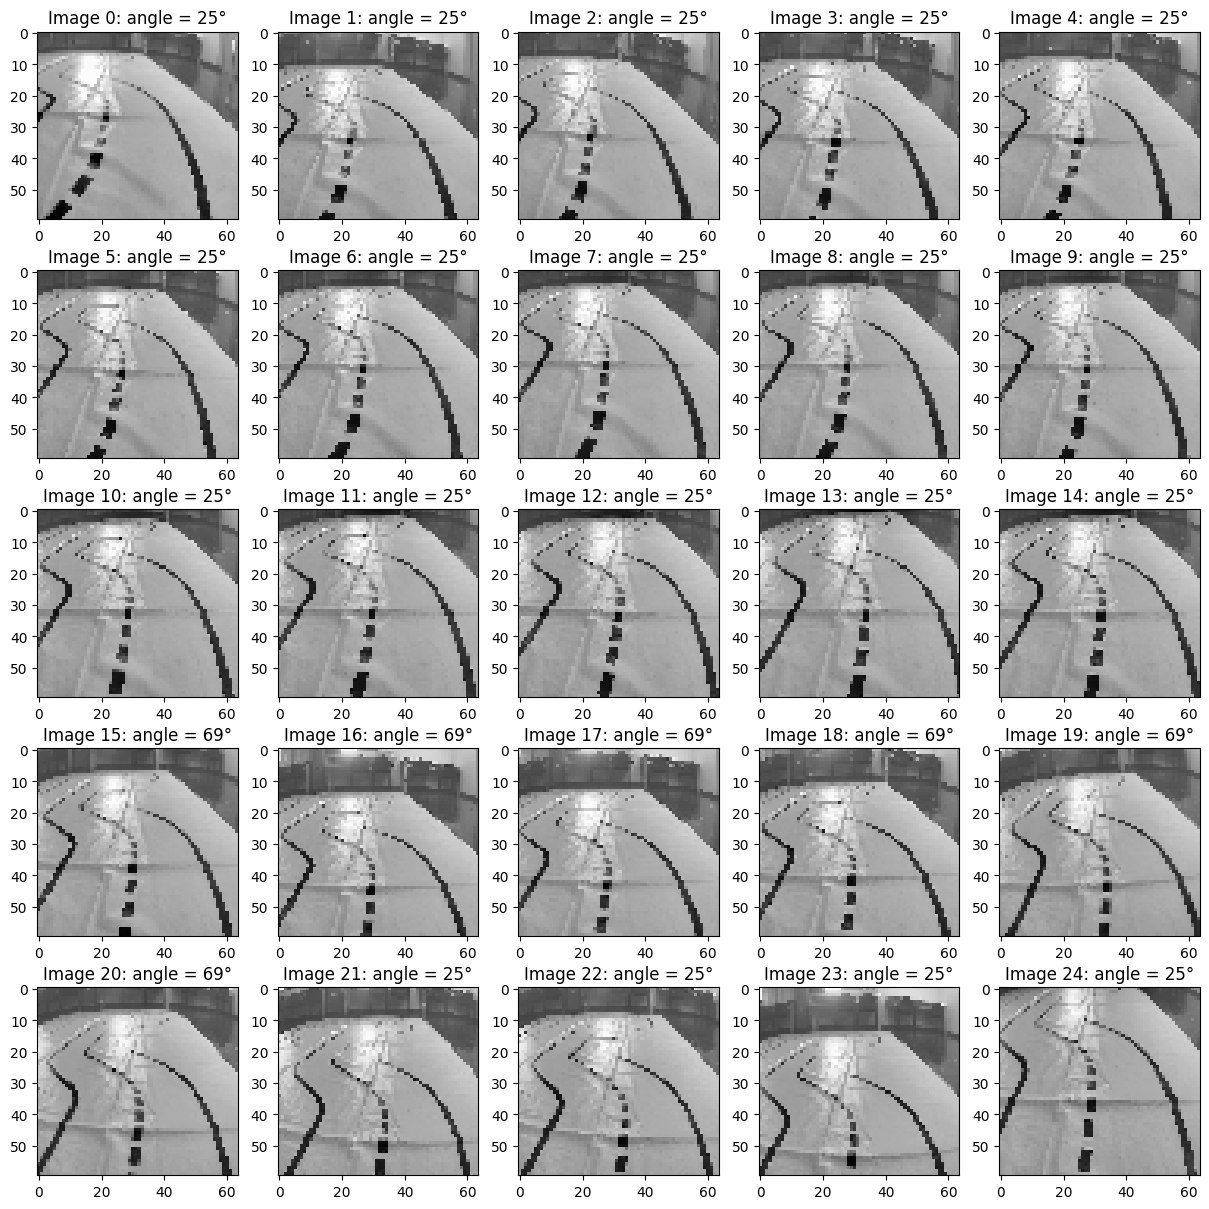

(232, 2)


In [101]:
v_i = 2
start = v_start[v_i]
rows, cols = (5, 5)

fig = plt.figure(figsize=(3*cols, 3*rows))
plots = fig.subplots(rows, cols)

for i, axes in enumerate(plots, 0):
    for j, ax in enumerate(axes,0):
        index = start + i*cols + j
        ax.imshow(imagenes[index,:,:], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Image {index}: angle = {df['dir'][index]}°")

plt.show()
print(df.shape)

In [100]:
# Elimina datos inválidos
rango = range(v_start[v_i],v_start[v_i]+17)
eliminarData(rango)

(232, 60, 64)


In [23]:
# Angle classification
def clasificador(ang):
    if ang < 10:
        return 0
    elif ang < 20:
        return 1
    elif ang < 30:
        return 2
    elif ang < 50:
        return 3
    else:
        return 4

In [102]:
df['encoded_angles'] = df['dir'].apply(clasificador)

In [103]:
print(df.shape)
print(imagenes.shape)
df.to_csv('data.csv', index=False)
np.save("img.npy", imagenes)

(232, 3)
(232, 60, 64)


## Training

### Carga de datos para el entrenamiento

In [55]:
with open('img.npy', 'rb') as f:
    imagenes = np.load(f)
df = pd.read_csv('data.csv')
print(f'Imagenes: {imagenes.shape}\nDatos:')
df.head

Imagenes: (339, 60, 64)
Datos:


<bound method NDFrame.head of       vel  dir  encoded_angles
0    6.60   25               2
1    6.60   25               2
2    6.60   25               2
3    6.60   25               2
4    6.60   25               2
..    ...  ...             ...
334  4.18   11               1
335  4.21   11               1
336  4.33   11               1
337  4.39   13               1
338  4.06   25               2

[339 rows x 3 columns]>

In [105]:
df.shape

(232, 3)

In [104]:
df[df['encoded_angles']==2].shape

(125, 3)

### Separación de train-test

In [56]:
import tensorflow as tf
# Carga librerias de Keras para redes neuronales
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import model_from_json
from keras.utils import np_utils

In [106]:
train_p = 0.7

angles = keras.utils.to_categorical(np.asarray(df['encoded_angles']))
images_training, images_testing, angles_training, angles_testing = train_test_split(imagenes, angles, test_size=0.3)


In [107]:
images_training.shape

(162, 60, 64)

### Definición de arquitectura

In [108]:
# Funcion para definir el modelo MLP de la figura de arriba
def define_modelo_MLP(bins):
    modelo = Sequential()  # Sequential indica que el modelo sera una pila de capas conec tadas secuencialmente (CNN) 
    modelo.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = (60, 64, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add( Flatten() ) 
    modelo.add( Dense(4, activation="sigmoid") ) 
    modelo.add( Dense(bins, activation="softmax") )
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
    return modelo

In [109]:
# evalua una arquitectura de modelo neuronal en k-fold cross-validation. Se pasa la funcion constructora del modelo
def evalua_modeloCV(model_buider, X, y, n_folds=5):
    accuracies, histories = list(), list()
    # prepara folds
    seed = 7   
    kfold = KFold(n_splits=n_folds, random_state=seed, shuffle= True) 
    
    # realiza la cross-validacion
    for train_ix, test_ix in kfold.split(X):   # por cada fold de test
        # define modelo MLP
        modelo = model_buider()
        # selecciona los sets de training y de test 
        trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
        # entrena el modelo
        history = modelo.fit(trainX, trainY, epochs=15, batch_size=32, validation_data=(testX, testY), verbose=0)
        # obtiene metricas de evaluacion en el fold de test del modelo entrenado 
        _, acc = modelo.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
         
        accuracies.append(acc)   # guarda la acuracia obtenida en el fold  de test
        histories.append(history)  # guarda hitórico de evolucion de scores entrenamiento  (loss y acuracias)
    return accuracies, histories

In [110]:
#How many bins is our data encoded into:
bins = angles_training.shape[1]

# Model
modelo = define_modelo_MLP(bins)  # llama a funcion que define el modelo
modelo.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 60, 64, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_15 (Flatten)        (None, 30720)             0         
                                                                 
 dense_30 (Dense)            (None, 4)                 122884    
                                                                 
 dense_31 (Dense)            (None, 5)                 25        
                                                                 
Total params: 123,229
Trainable params: 123,229
Non-trainable params: 0
_______________________________________________

### Entrenamiento

In [111]:
cv_accuracies, cv_histories = evalua_modeloCV(lambda: define_modelo_MLP(bins), images_training, angles_training, 5)

> 54.545
> 48.485
> 62.500
> 40.625
> 37.500


In [112]:
# define modelo final
modelo_finalMLP = define_modelo_MLP(bins)

# entrena  modelo final
modelo_finalMLP.fit(images_training, angles_training, epochs=30, batch_size=32, verbose=0)  # verbose=0  es para no mostrar informacion de entrenamiento

# evalua modelo final en  dataset de validacion
_, acc = modelo_finalMLP.evaluate(images_testing, angles_testing, verbose=0)
print('Accuracy > %.3f' % (acc * 100.0))


Accuracy > 65.714


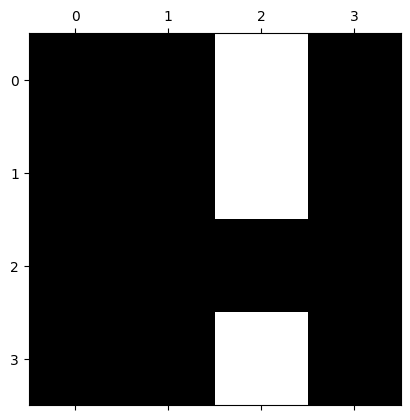

In [113]:
# obtiene las categorias de las muestras de validacion (lo contrario de one hot)
true_labels = np.argmax(angles_testing, axis=1)
predictions_test_MLP = modelo_finalMLP.predict(images_testing, verbose=0 ) 
predicted_labels_MLP = np.argmax(predictions_test_MLP, axis=1)

# obtiene matriz de confusion
conf_mx = confusion_matrix(true_labels, predicted_labels_MLP)

# normaliza las filas de la matriz de confusion
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# coloca 0 en la diagonal para enfocarnos en los errores 
np.fill_diagonal(norm_conf_mx, 0)

# plotea 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [114]:
conf_mx

array([[ 0,  0,  6,  0],
       [ 0,  0, 13,  0],
       [ 0,  0, 46,  0],
       [ 0,  0,  5,  0]], dtype=int64)

## Guardar modelo

In [115]:
# salva los pesos en archivo h5
modelo_finalMLP.save("modelo_alvinn.h5")
print("Modelo salvado en disco")

Modelo salvado en disco


## Cargar modelo

In [ ]:
from keras.models import load_model
modelo_cargado = load_model('modelo_alvinn.h5')
# output = modelo_cargado.predict(img_processed)
# print(output)